In [1]:
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
from ucimlrepo import fetch_ucirepo

# fetch dataset
htru2 = fetch_ucirepo(id=372)

# data (as pandas dataframes)
X = htru2.data.features
y = htru2.data.targets

y = y.values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [3]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

# Define resampling techniques
resampling_techniques = {
    'Baseline': (X_train, y_train),
    'Random Undersampling': RandomUnderSampler(random_state=42).fit_resample(X_train, y_train),
    'Random Oversampling': RandomOverSampler(random_state=42).fit_resample(X_train, y_train),
    'SMOTE': SMOTE(random_state=42).fit_resample(X_train, y_train),
    'AllKNN (SMOTEENN)': SMOTEENN(random_state=42).fit_resample(X_train, y_train)
}


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Define machine learning algorithms
ml_algorithms = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

# Define deep learning algorithms
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.layer1 = nn.Linear(8, 16)
        self.layer2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

def train_and_evaluate_ann(X_train, y_train, X_test, y_test):
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).view(-1, 1))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleANN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred)
    }


In [5]:
results = []

for method, (X_resampled, y_resampled) in resampling_techniques.items():
    print(f"\nEvaluating {method}")

    for algo_name, model in ml_algorithms.items():
        print(f"Algorithm: {algo_name}")
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        metrics = {
            'Method': method,
            'Algorithm': algo_name,
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred)
        }
        results.append(metrics)

    # Convert to NumPy arrays if necessary
    if isinstance(X_resampled, pd.DataFrame):
        X_resampled = X_resampled.values
    if isinstance(y_resampled, pd.DataFrame):
        y_resampled = y_resampled.values
    if y_resampled.ndim > 1:
        y_resampled = y_resampled.ravel()

    # Evaluate ANN
    ann_metrics = train_and_evaluate_ann(X_resampled, y_resampled, X_test, y_test)
    ann_metrics.update({'Method': method, 'Algorithm': 'ANN'})
    results.append(ann_metrics)



Evaluating Baseline
Algorithm: Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Algorithm: Random Forest


<ipython-input-5-bc8002ef2f27>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_resampled, y_resampled)


Algorithm: SVM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Algorithm: Extra Trees


<ipython-input-5-bc8002ef2f27>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_resampled, y_resampled)



Evaluating Random Undersampling
Algorithm: Logistic Regression
Algorithm: Random Forest
Algorithm: SVM
Algorithm: Extra Trees

Evaluating Random Oversampling
Algorithm: Logistic Regression
Algorithm: Random Forest
Algorithm: SVM
Algorithm: Extra Trees

Evaluating SMOTE
Algorithm: Logistic Regression
Algorithm: Random Forest
Algorithm: SVM
Algorithm: Extra Trees

Evaluating AllKNN (SMOTEENN)
Algorithm: Logistic Regression
Algorithm: Random Forest
Algorithm: SVM
Algorithm: Extra Trees


<ipython-input-6-fc3fe4bc5903>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-6-fc3fe4bc5903>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
<ipython-input-6-fc3fe4bc5903>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-6-fc3fe4bc5903>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')


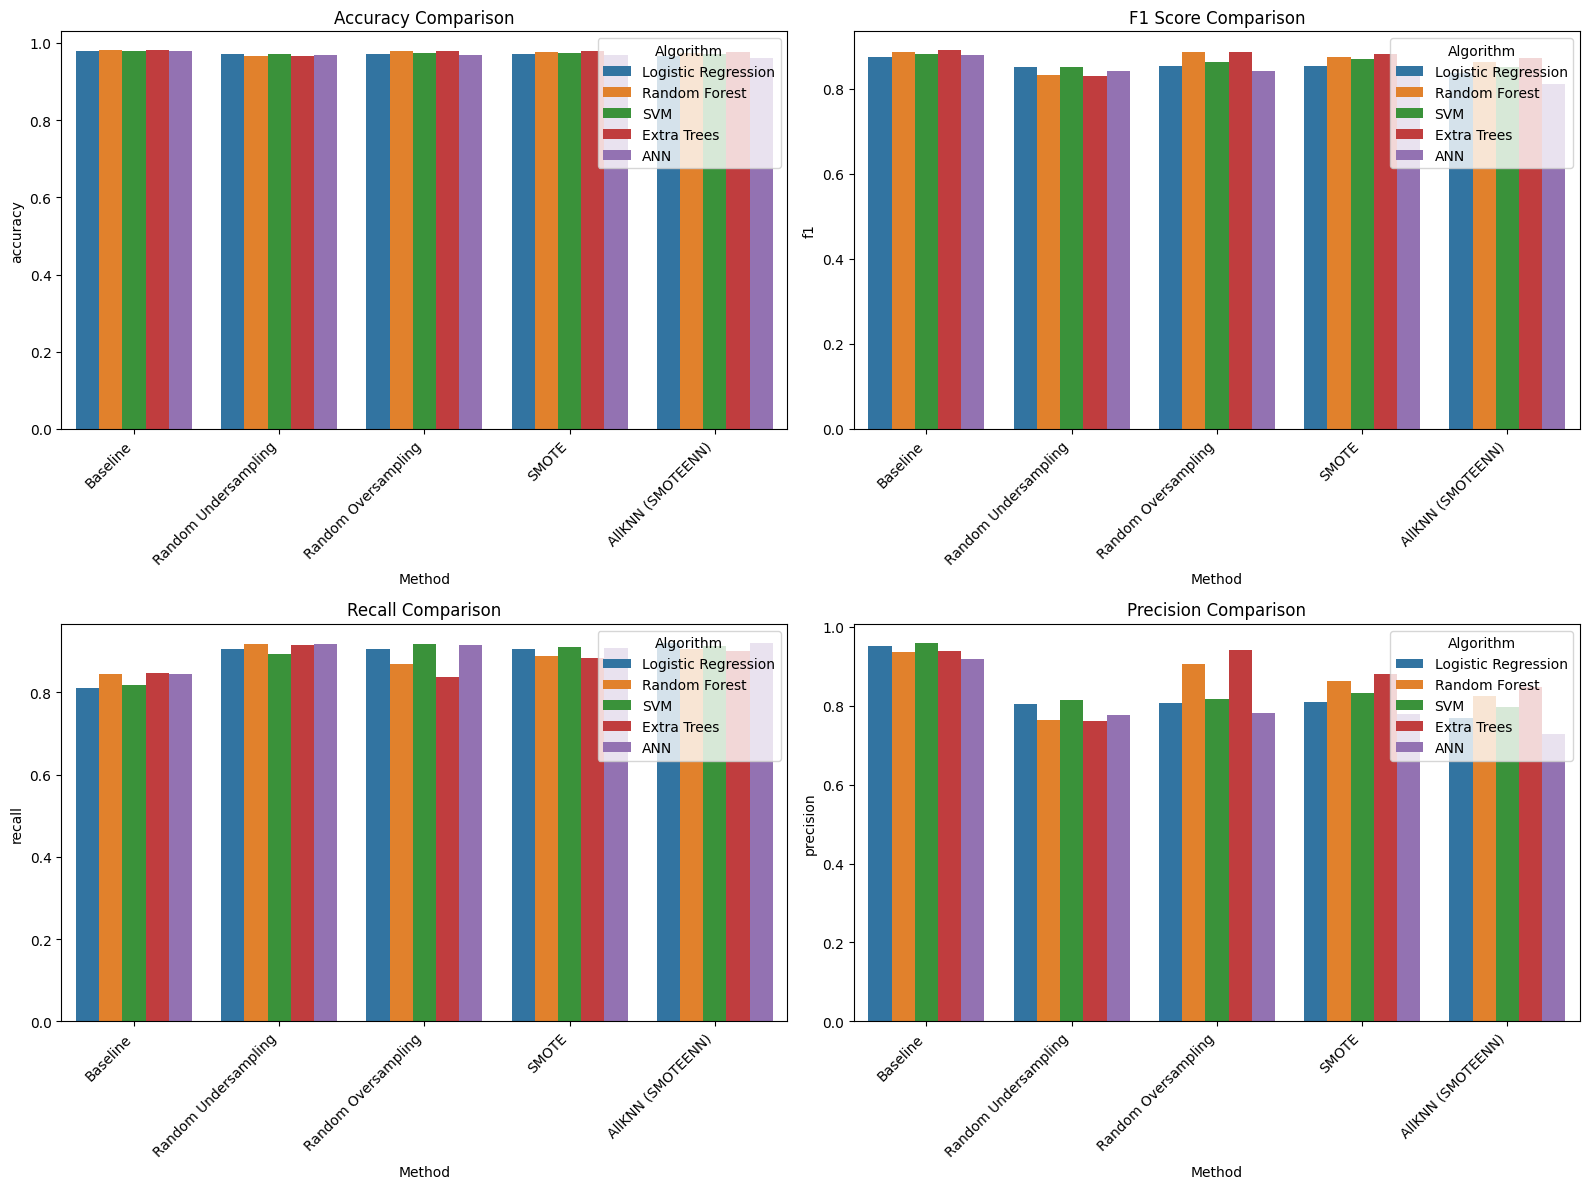

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(data=results_df, x='Method', y='accuracy', hue='Algorithm', ax=axes[0, 0])
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

sns.barplot(data=results_df, x='Method', y='f1', hue='Algorithm', ax=axes[0, 1])
axes[0, 1].set_title('F1 Score Comparison')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

sns.barplot(data=results_df, x='Method', y='recall', hue='Algorithm', ax=axes[1, 0])
axes[1, 0].set_title('Recall Comparison')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

sns.barplot(data=results_df, x='Method', y='precision', hue='Algorithm', ax=axes[1, 1])
axes[1, 1].set_title('Precision Comparison')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [7]:
print(results_df)

                  Method            Algorithm  accuracy        f1    recall  \
0               Baseline  Logistic Regression  0.978771  0.875000  0.810976   
1               Baseline        Random Forest  0.980447  0.887940  0.845528   
2               Baseline                  SVM  0.980074  0.882547  0.817073   
3               Baseline          Extra Trees  0.981006  0.891026  0.847561   
4               Baseline                  ANN  0.978957  0.880423  0.845528   
5   Random Undersampling  Logistic Regression  0.971136  0.851958  0.906504   
6   Random Undersampling        Random Forest  0.966294  0.832872  0.916667   
7   Random Undersampling                  SVM  0.971508  0.851888  0.894309   
8   Random Undersampling          Extra Trees  0.965736  0.830258  0.914634   
9   Random Undersampling                  ANN  0.968343  0.841713  0.918699   
10   Random Oversampling  Logistic Regression  0.971508  0.853589  0.906504   
11   Random Oversampling        Random Forest  0.979